This Notebook presents an attempt to build a model that learns image segmentation using convolutional neural networks ,by building a very simple model .


1.   The dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.[link text](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)
      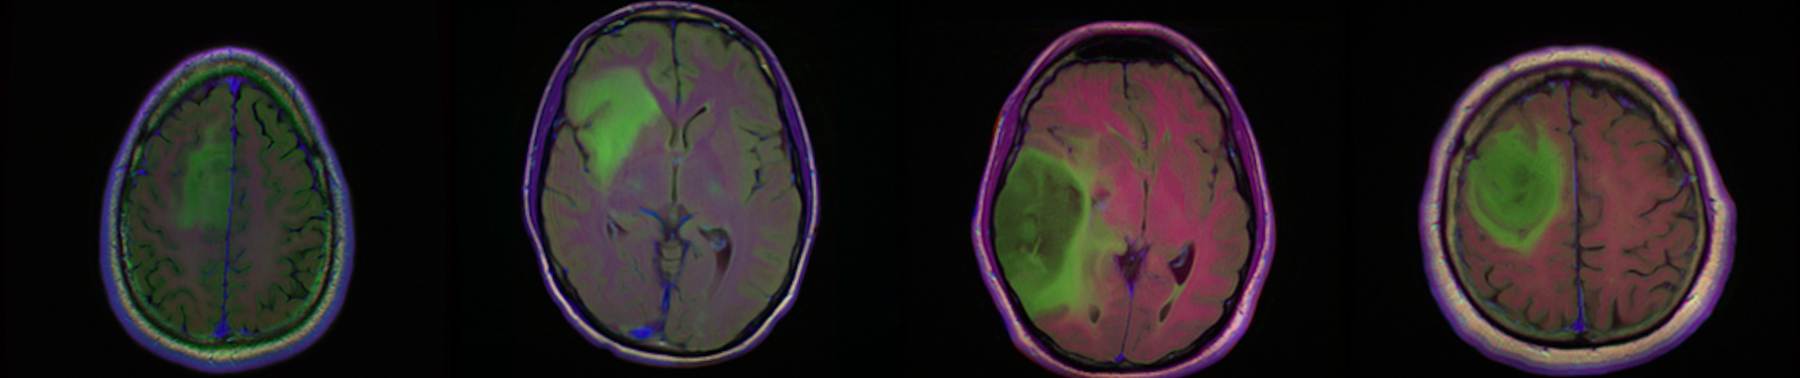  



In [1]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bahriaymen","key":"a13346c4c42326125bedf0153e4a7d20"}'}

In [2]:
#create kaggle hidden dir and copy the json file to it 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#download data 
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 97% 696M/714M [00:05<00:00, 208MB/s]
100% 714M/714M [00:05<00:00, 136MB/s]


In [4]:
!unzip -qq lgg-mri-segmentation.zip

### we end up with a directory of subdirectories ,each one of them contains images and their masks ,what need to be done next is to regroupe paths to masks and input images separately in two lists that I will simply call targets and input_img_paths ,this step is needed later when spliting the data into batches ,where I'll define a BatchGenerator class that provides me with targets and input_imgs as batches of data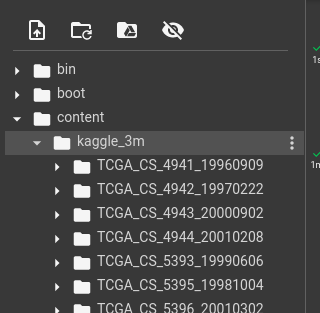

In [5]:
import os
input_dir = "kaggle_3m/" #input directory 
sub_dirs_paths = [os.path.join(input_dir,sub_dir) for sub_dir in os.listdir(input_dir) if not(sub_dir.endswith(".md") or sub_dir.endswith(".csv"))]#holds  paths to subdirectories

input_img_paths = []     
targets = []
#loop over subdirectories ,inside each subdir,if the name contains (mask.tif) put its path  into targets otherwise into input_imgs_paths
for path in sub_dirs_paths:            
  for fname in os.listdir(path):
    if fname.endswith("mask.tif"):
      targets.append(os.path.join(path,fname))
    else:
      input_img_paths.append(os.path.join(path,fname))



In [6]:
#sort input_imgs and targets
input_img_paths.sort()
targets.sort()

In [8]:
#check the first few paths  
for i in range(5):
  print(input_img_paths[i],"\t",targets[i])

kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif


its clear that even with sort the files  doesn't correspond one to another so I need to sort them manually ,for each name in the input_img_paths ,I search for the exact mask corresponding to it and place it at the same index 

In [9]:
#sort  targets mannualy by extracting names and comparing them ,
new_targets = []
for path in input_img_paths:
  for target in targets:
    name = path.split("/")[-1].split(".")[0]
    mask_name = "_".join(target.split("/")[-1].split("_")[:-1])
    if(name == mask_name):
      new_targets.append(target)



In [10]:
#check again
for i in range(5):
  print(input_img_paths[i],"\t",new_targets[i])

kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif


In [11]:
#total number of  images 
len(new_targets)

3929

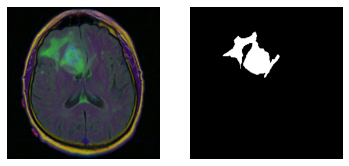

In [12]:
#visulaize and image and its mask 
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img,img_to_array

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(load_img(input_img_paths[5]))
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(load_img(new_targets[5]))

In [13]:
#check targets shape and range of values ,for resizing and normalization later 
img_to_array(load_img(new_targets[4])).max(),img_to_array(load_img(new_targets[4])).shape #the mask is all zeros and 255 in the tumor region 

(255.0, (256, 256, 3))

since its a sort of binary classification problem ,i.e each pixel in the target mask will be either 255 or 0 its better to normalize all the targets to (0,1) range ,also I will try to create a batch generator that generates batch of data in each call ,this will be called in a fit function to provide the data loss will be computed using tensorflow GradientTape,and accuracy will be implemented  mannualy .

In [14]:
#creating a batch generator 
import math
from tensorflow.keras.utils import load_img,img_to_array
import numpy as np
import random

class BatchGenerator:
    def __init__(self,input_paths,target_paths,img_size,num_val_samples=200,batch_size = 32):
        self.index = 0
        self.index1 = 0                                                #holds from wich index to extract the batch                 
        self.input_paths= input_paths
        self.target_paths = target_paths                              #target images paths
        self.batch_size = batch_size
        self.num_batches = math.ceil((len(input_paths)-num_val_samples) / self.batch_size)
        self.img_size = img_size
        self.nval = num_val_samples

        random.Random(1337).shuffle(self.input_paths[:-self.nval])                #use seed to suffle input images and targets in the same manner as not to lose which mask correspond to which image
        random.Random(1337).shuffle(self.target_paths[:-self.nval])



    def path_to_input_image(self,path):
      """Returns the resized image from the specified path"""
      return img_to_array(load_img(path,target_size=self.img_size))

    def path_to_target(self,path):
      """Returns the resized and normalized  mask from the specified path"""
      img = img_to_array(load_img(path,target_size=self.img_size,color_mode="grayscale"))   #one channel only
      img = img/255                                                         #pixel values are either (0 or 255)  ,so they becomes (0,1) and it turns to a binary classification problem
      return img.astype("uint8")

    def input_target(self):
      """         Returns tensors of images and target in batchs of size batch_size"""

      num_imgs = len(self.input_paths)
      input_imgs = np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
      targets  =np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
      for i in range(self.batch_size):
          input_imgs[i] = self.path_to_input_image(self.input_paths[self.index+i])
          targets[i] = self.path_to_target(self.target_paths[self.index+i])
      return input_imgs,targets
    
    def val_data(self):
      num_imgs = len(self.input_paths)
      input_imgs = np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
      targets  =np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
      im_paths = self.input_paths[-self.nval:]
      target_paths = self.target_paths[-self.nval:]
      if(self.index1 >self.nval-self.batch_size):
        self.index1 = 0
      for i in range(self.batch_size):
          input_imgs[i] = self.path_to_input_image(im_paths[self.index1+i]) #extract samples from the last 1000 paths
          targets[i] = self.path_to_target(target_paths[self.index1+i])
      return input_imgs,targets

    def next(self):
        """next batch """
        input_imgs,targets = self.input_target()
        val_images,val_targets = self.val_data()
        self.index += self.batch_size
        self.index1 += self.batch_size
        return input_imgs,targets,val_images,val_targets

In [15]:
import tensorflow as tf

optimizer = tf.keras.optimizers.RMSprop()                   
accuracy = tf.keras.metrics.Accuracy()                  # instanciate accuracy metric for validation and train
val_accuracy=tf.keras.metrics.Accuracy()
def one_training_step(model,image_batch,target_batch,val_images,val_targets):
    """computes average loss and train accuracy over a single batch """
    with tf.GradientTape() as tape:
        predictions = model(image_batch)              
        predictions_=np.argmax(predictions,axis=-1)  # to reshape predicitons as targets by taking the maximum between the two channels since pred contains two channels
        accuracy.reset_state()                       #reset
        accuracy.update_state(predictions_,target_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(target_batch,predictions)
        average_loss = tf.reduce_mean(per_sample_losses)

        val_predictions = model(val_images)
        val_predictions_= np.argmax(val_predictions,axis=-1)
        val_accuracy.reset_state()
        val_accuracy.update_state(val_predictions_,val_targets)


    gradients = tape.gradient(average_loss,model.weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return average_loss,accuracy.result().numpy(),val_accuracy.result().numpy()

In [19]:
def fit(model,images_path,targets_path,epochs,img_size=(256,256),batch_size = 32):
    history = {}
    for epoch_counter in range(epochs):
        print(f"Epoch:{epoch_counter}")
        batch_genrator = BatchGenerator(images_path,targets_path,img_size)   #create a batch_generator instance
        for batch_counter in range( batch_genrator.num_batches-1):          #loop over batches 
            images_batch,targets_batch,val_images,val_targets = batch_genrator.next()                        
            loss ,acc,val_acc= one_training_step(model,images_batch,targets_batch,val_images,val_targets)
            if(batch_counter % 10 == 0):
              print(f"loss at batch  {batch_counter}:{loss:.2f} \t accuracy {batch_counter}:{acc:.2f} \t val_accuracy {batch_counter}:{val_acc:.2f} ")
            history.setdefault("loss",[]).append(loss)
            history.setdefault("accuracy",[]).append(acc)
            history.setdefault("val_acc",[]).append(val_acc)
    return history

        

        

In [17]:
from keras.api._v2.keras import activations
from tensorflow import keras
from tensorflow.keras import layers

#input a (256,256,3) image and get a (256,256,2) output with (0,1) classes
img_size = (256,256)
def get_model(img_size,num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

#downsampling layers
  x = layers.Conv2D(32,3,strides = 2,activation="relu",padding="same")(x)   
  x = layers.Conv2D(32,3,activation="relu",padding="same")(x)
  x = layers.Conv2D(128,3,strides = 2,activation="relu",padding="same")(x)   
  x = layers.Conv2D(128,3,activation="relu",padding="same")(x)  


#upsampling layers
  x = layers.Conv2DTranspose(128,3,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(128,3,strides = 2,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(32,3,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(32,3,strides = 2,activation="relu",padding="same")(x)

  outputs = layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)
  model = keras.Model(inputs,outputs)

  return model

model = get_model(img_size,num_classes=2) #number of classes is 2 because it a sort of  binary problem where each pixel in the image will get a class (either 0 or 1)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      147584

In [20]:
history = fit(model,input_img_paths,new_targets,epochs=10,batch_size=32)

Epoch:0
loss at batch  0:0.03 	 accuracy 0:0.99 	 val_accuracy 0:1.00 
loss at batch  10:0.04 	 accuracy 10:0.99 	 val_accuracy 10:0.99 
loss at batch  20:0.05 	 accuracy 20:0.99 	 val_accuracy 20:0.99 
loss at batch  30:0.01 	 accuracy 30:1.00 	 val_accuracy 30:1.00 
loss at batch  40:0.06 	 accuracy 40:0.97 	 val_accuracy 40:0.99 
loss at batch  50:0.07 	 accuracy 50:0.98 	 val_accuracy 50:0.99 
loss at batch  60:0.02 	 accuracy 60:1.00 	 val_accuracy 60:1.00 
loss at batch  70:0.01 	 accuracy 70:1.00 	 val_accuracy 70:0.99 
loss at batch  80:0.05 	 accuracy 80:0.99 	 val_accuracy 80:0.99 
loss at batch  90:0.03 	 accuracy 90:0.98 	 val_accuracy 90:1.00 
loss at batch  100:0.05 	 accuracy 100:0.96 	 val_accuracy 100:0.99 
loss at batch  110:0.17 	 accuracy 110:0.97 	 val_accuracy 110:0.99 
Epoch:1
loss at batch  0:0.05 	 accuracy 0:0.99 	 val_accuracy 0:1.00 
loss at batch  10:0.03 	 accuracy 10:0.99 	 val_accuracy 10:0.99 
loss at batch  20:0.04 	 accuracy 20:0.99 	 val_accuracy 20:

In [21]:
 #testing the model on  an exemple
from tensorflow.keras.utils import array_to_img,img_to_array,load_img

test_image = img_to_array(load_img(input_img_paths[7],target_size=(256,256)))
test_mask = img_to_array(load_img(new_targets[7],target_size=(256,256)))

(-0.5, 255.5, 255.5, -0.5)

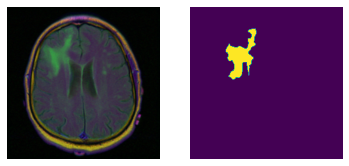

In [22]:
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(test_image.astype("uint8"))
plt.subplot(1,2,2)
plt.imshow(test_mask[:,:,0])
plt.axis("off")




In [23]:
mask = model.predict(np.expand_dims(test_image, 0))[0]
mask.shape

1/1 [==============================] - 1s 659ms/step


(256, 256, 2)

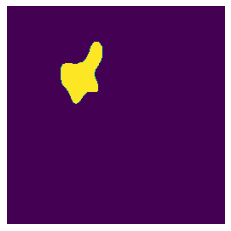

In [24]:
#predicting the mask ofthe test sample
mask = np.argmax(mask, axis=-1)#build an array by extracting the max value from the channels build a single channel array
mask *= 255
plt.axis("off")
plt.imshow(mask)

prediction is not quit good even in a an already seen sample

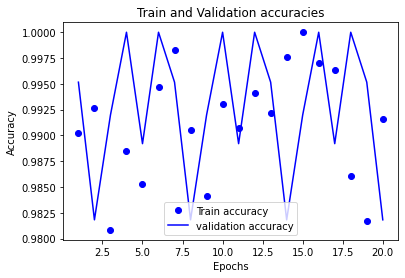

In [29]:

import matplotlib.pyplot as plt
train_loss =history["accuracy"][:20]
val_loss = history["val_acc"][:20]
epochs = range(1,len(train_loss) + 1)
plt.plot(epochs[:20],train_loss,"bo",label = "Train accuracy")
plt.plot(epochs[:20],val_loss,"b",label = "validation accuracy")
plt.title("Train and Validation accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

     


### its clear that the loss function is stalling in local optimum and even in an already seen data the model isn't giving accurate predictions 

In [36]:
test_image = img_to_array(load_img(input_img_paths[-50],target_size=(256,256))) #extract a sample from validation 
test_mask = img_to_array(load_img(new_targets[-50],target_size=(256,256)))

(-0.5, 255.5, 255.5, -0.5)

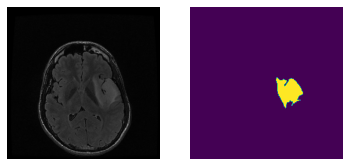

In [37]:
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(test_image.astype("uint8"))
plt.subplot(1,2,2)
plt.imshow(test_mask[:,:,0])
plt.axis("off")

In [38]:
mask = model.predict(np.expand_dims(test_image, 0))[0]
mask.shape

1/1 [==============================] - 0s 21ms/step


(256, 256, 2)

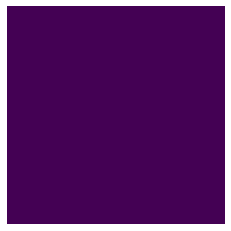

In [39]:
#predicting the mask ofthe test sample
mask = np.argmax(mask, axis=-1)#build an array by extracting the max value from the channels build a single channel array
mask *= 255
plt.axis("off")
plt.imshow(mask)

###the model is not quit good after all 